## 1. Introduction

* Brief overview of wind energy in Ireland

* Purpose of the analysis

* Key questions being addressed

(Keep this short: ~1–2 paragraphs)

## 2. Data Acquisition

* Description of Met Éireann dataset

* Time period covered

* Weather variables used

Include:

import pandas as pd

## 3. Data Cleaning and Preparation

This section is very important for marks.

Include:

* Handling missing values

* Data type conversions

* Column renaming

* Date parsing

* Feature creation (year, month)

Explain why each step is necessary.

## 4. Exploratory Data Analysis (EDA)

Suggested analyses:

* Overall wind speed distribution

* Monthly average wind speeds

* Yearly average wind speeds

Suggested plots:

* Histogram of wind speeds

* Line plot of monthly averages

* Boxplot of wind speed by month

Make plots:

* Large

* Labelled

Easy to read

## 5. Wind Energy Potential Analysis

Explain basic turbine constraints:

* Cut-in speed (~3 m/s)

* Rated range

* Cut-out speed (~25 m/s)

Analyses:

* Percentage of time wind is usable

* Seasonal differences in usable wind

This shows real-world application, not just coding.

## 6. Trend Analysis Using Machine Learning

Use **SciKit-Learn**  here.

Steps:

* Aggregate yearly mean wind speed

* Apply linear regression

Visualise trend

Answer:

* Is there a noticeable trend?

* What does it imply for future wind energy?

## 7. Discussion

* Interpret results

* Explain what the trends mean

* Mention data limitations

Bullet points are fine.

## 8. Conclusion

* Directly answer original questions

* Summarise findings

* Suggest future work

Short and clear.

## 1. Introduction

Ireland has strong and consistent winds, making wind energy a key part of its renewable energy mix. This analysis examines the availability and variability of wind power, considering factors like typical wind speeds, seasonal and daily patterns, and trends over time. It also explores how weather forecasts and other conditions may affect wind farm output in the near future.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

## Met Éireann Dataset

The analysis uses historical climate data from Met Éireann, Ireland’s national meteorological service. Data are obtained from four representative stations across the country: Malin Head, Mace Head, Valentia Observatory, and Dublin Airport. The datasets are provided as daily CSV files containing measurements such as wind speed, wind gusts, temperature, and precipitation. These records allow analysis of temporal patterns, seasonal trends, and regional variations in Ireland’s wind and weather conditions. Using multiple stations ensures that both coastal and inland wind conditions are captured, providing a more complete picture for wind energy assessment.

### For wind energy analysis, the most relevant columns are:

* Mean wind speed (m/s)

* Maximum wind gusts

* Observation date

* Temperature and precipitation, which can affect turbine efficiency and maintenance


The CSV files for each station can be accessed at the following URLs:

* Malin Head: [dly1575.csv](https://cli.fusio.net/cli/climate_data/webdata/dly1575.csv)

* Mace Head: [dly275.csv](https://cli.fusio.net/cli/climate_data/webdata/dly275.csv)

* Valentia Observatory: [dly2275.csv](https://cli.fusio.net/cli/climate_data/webdata/dly2275.csv)

* Dublin Airport: [dly532.csv](https://cli.fusio.net/cli/climate_data/webdata/dly532.csv)

In [ ]:



# URLs for Met Éireann climate data CSV files
stations = {
    "Malin Head": "https://cli.fusio.net/cli/climate_data/webdata/dly1575.csv",
    "Mace Head": "https://cli.fusio.net/cli/climate_data/webdata/dly275.csv",
    "Valentia Observatory": "https://cli.fusio.net/cli/climate_data/webdata/dly2275.csv",
    "Dublin Airport": "https://cli.fusio.net/cli/climate_data/webdata/dly532.csv"
}




Malin Head           date  ind  maxtp  ind.1  mintp igmin gmin  ind.2  rain    cbl  ...  \
0  01-may-1955    0    9.4      0    6.9     0  3.8      0   7.4  996.2  ...   
1  02-may-1955    0   11.2      0    5.7     0  5.9      3   0.0  997.1  ...   
2  03-may-1955    0   13.1      0    4.3     0  0.6      0   6.6  989.6  ...   
3  04-may-1955    0   12.8      0    7.8     0  6.1      0   4.4  978.3  ...   
4  05-may-1955    0   13.2      0    8.1     0  6.6      0   2.7  990.3  ...   

  ind.5  hg sun  glorad    soil   pe evap smd_wd smd_md smd_pd  
0     2  48                      1.0  1.9                       
1     0  31              12.300  1.9  3.6                       
2     0  48               9.200  1.4  2.4                       
3     0  41               9.625  2.0  3.6                       
4     0  34              10.775  2.0  3.4                       

[5 rows x 25 columns]
Mace Head           date  ind maxtp  ind.1 mintp igmin gmin  ind.2 rain     cbl  ...  \
0  14-a

In [ ]:
# Load each CSV into a dictionary of DataFrames
# Met Éireann files have header rows that need to be skipped
data = {name: pd.read_csv(url, skiprows=24) for name, url in stations.items()}

# Quick check
for name, df in data.items():
    print(name, df.head())

In [703]:
df['date'] = pd.to_datetime(df['date'])

C:\Users\finia\AppData\Local\Temp\ipykernel_23420\3532345252.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [704]:
df_indexed = df.set_index('date').loc['2000-01-01':'2025-12-31']

df_indexed[['wdsp', 'hm', 'hg', 'ddhm']]

,wdsp,hm,hg,ddhm
date,,,,
2000-01-01,7.6,16,23,220
2000-01-02,12.0,23,37,220
2000-01-03,10.9,30,41,250
2000-01-04,13.7,24,38,250
2000-01-05,21.4,30,47,210
...,...,...,...,...
2025-11-26,7.4,13,24,220
2025-11-27,12.8,19,36,260
2025-11-28,12.5,19,35,210


In [705]:


# Create full daily date range
full_range = pd.date_range(
    start='2000-01-01',
    end='2025-12-31',
    freq='D'
)

# Reindex to include missing dates
df_indexed = df_indexed.reindex(full_range)
df_indexed.index.name = 'date'


In [706]:
cols = ['wdsp', 'hm', 'hg', 'ddhm']

# Backfill first, then forward-fill as a safety net
df_filled = df_indexed[cols].bfill().ffill()


In [707]:
# Convert columns to numeric first
df_filled_numeric = df_filled.apply(pd.to_numeric, errors='coerce')

# Now compute statistics
stats = df_filled_numeric.agg(['mean', 'std'])
print(stats)


           wdsp         hm         hg        ddhm
mean  10.219269  17.609350  25.390334  204.266611
std    4.175080   6.216136   9.014007   85.046395


In [708]:
means = df_filled_numeric.mean()
stds  = df_filled_numeric.std()

print("Means:\n", means)
print("\nStandard Deviations:\n", stds)


Means:
 wdsp     10.219269
hm       17.609350
hg       25.390334
ddhm    204.266611
dtype: float64

Standard Deviations:
 wdsp     4.175080
hm       6.216136
hg       9.014007
ddhm    85.046395
dtype: float64


In [709]:
dfs = []

for station, url in stations.items():
    df = pd.read_csv(url, skiprows=24)
    df["station"] = station
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)


In [710]:
# Convert date to datetime and extract year and month
combined_df['date'] = pd.to_datetime(combined_df['date'], format='%d-%b-%Y', errors='coerce')
combined_df['year'] = combined_df['date'].dt.year
combined_df['month'] = combined_df['date'].dt.month
combined_df['week'] = combined_df['date'].dt.isocalendar().week
combined_df['day'] = combined_df['date'].dt.day

# Convert wind speed from knots to m/s (1 knot = 0.514444 m/s)
combined_df['wind_speed_ms'] = pd.to_numeric(combined_df['wdsp'], errors='coerce') * 0.514444

# Group by station and month
monthly_wind = combined_df.groupby(['station', 'month'])['wind_speed_ms'].mean().unstack()


# Group by station and week
weekly_wind = combined_df.groupby(['station', 'week'])['wind_speed_ms'].mean().unstack()

# Group by station and daily date
daily_wind = combined_df.groupby(['station', 'date'])['wind_speed_ms'].mean().unstack()


In [711]:
stations = {
    "Malin Head": "https://cli.fusio.net/cli/climate_data/webdata/dly1575.csv",
    "Mace Head": "https://cli.fusio.net/cli/climate_data/webdata/dly275.csv",
    "Valentia Observatory": "https://cli.fusio.net/cli/climate_data/webdata/dly2275.csv",
    "Dublin Airport": "https://cli.fusio.net/cli/climate_data/webdata/dly532.csv"
}


In [712]:
# Convert hg from object to numeric and calculate monthly averages
combined_df['hg_numeric'] = pd.to_numeric(combined_df['hg'], errors='coerce')
weekly_hg = combined_df.groupby(['station', 'week'])['hg_numeric'].mean().unstack()
monthly_hg = combined_df.groupby(['station', 'month'])['hg_numeric'].mean().unstack()
yearly_hg = combined_df.groupby(['station', 'year'])['hg_numeric'].mean().unstack()

# convert wdsp to numeric and calculate monthly averages
combined_df['wdsp_numeric'] = pd.to_numeric(combined_df['wdsp'], errors='coerce')
weekly_wind = combined_df.groupby(['station', 'week'])['wdsp_numeric'].mean().unstack()
monthly_wind = combined_df.groupby(['station', 'month'])['wdsp_numeric'].mean().unstack()
yearly_wind = combined_df.groupby(['station', 'year'])['wind_speed_ms'].mean().unstack()

# Convert ddhm to numeric and calculate monthly averages
combined_df['ddhm_numeric'] = pd.to_numeric(combined_df['ddhm'], errors='coerce')
weekly_ddhm = combined_df.groupby(['station', 'week'])['ddhm_numeric'].mean().unstack()
monthly_ddhm = combined_df.groupby(['station', 'month'])['ddhm_numeric'].mean().unstack()
yearly_ddhm = combined_df.groupby(['station', 'year'])['ddhm_numeric'].mean().unstack()

# Convert hm to numeric and calculate monthly averages
combined_df['hm_numeric'] = pd.to_numeric(combined_df['hm'], errors='coerce')
weekly_hm = combined_df.groupby(['station', 'week'])['hm_numeric'].mean().unstack()
monthly_hm = combined_df.groupby(['station', 'month'])['hm_numeric'].mean().unstack()
yearly_hm = combined_df.groupby(['station', 'year'])['hm_numeric'].mean().unstack()



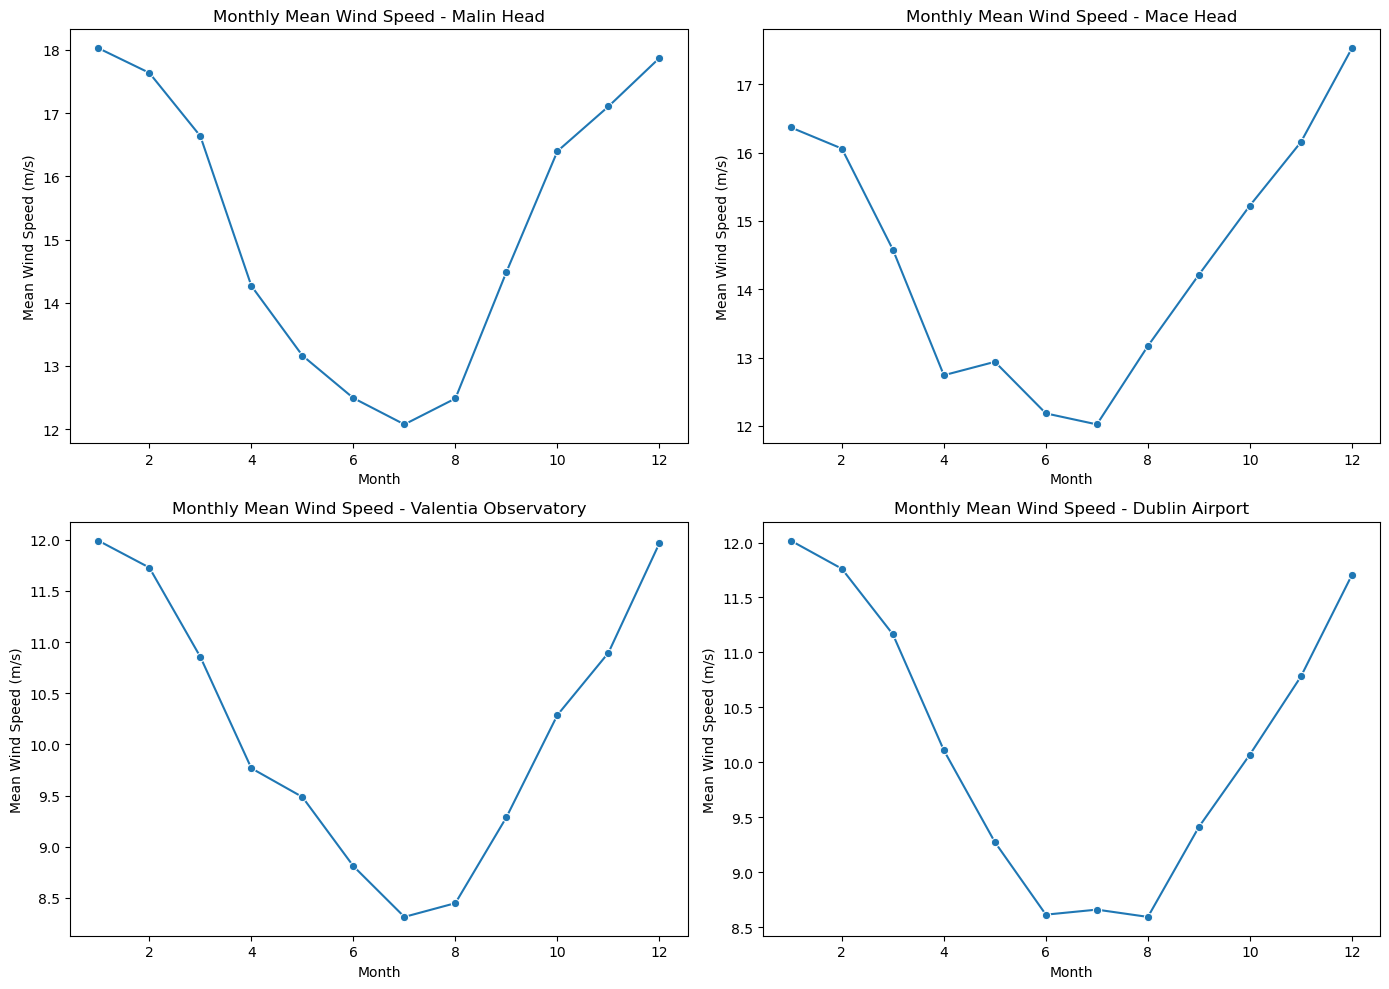

In [713]:
# Create subplots for all stations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, station in enumerate(stations.keys()):
    sns.lineplot(data=monthly_wind.loc[station], ax=axes[i], marker='o')
    axes[i].set_title(f'Monthly Mean Wind Speed - {station}')
    axes[i].set_ylabel('Mean Wind Speed (m/s)')
    axes[i].set_xlabel('Month')
plt.tight_layout()
plt.show()

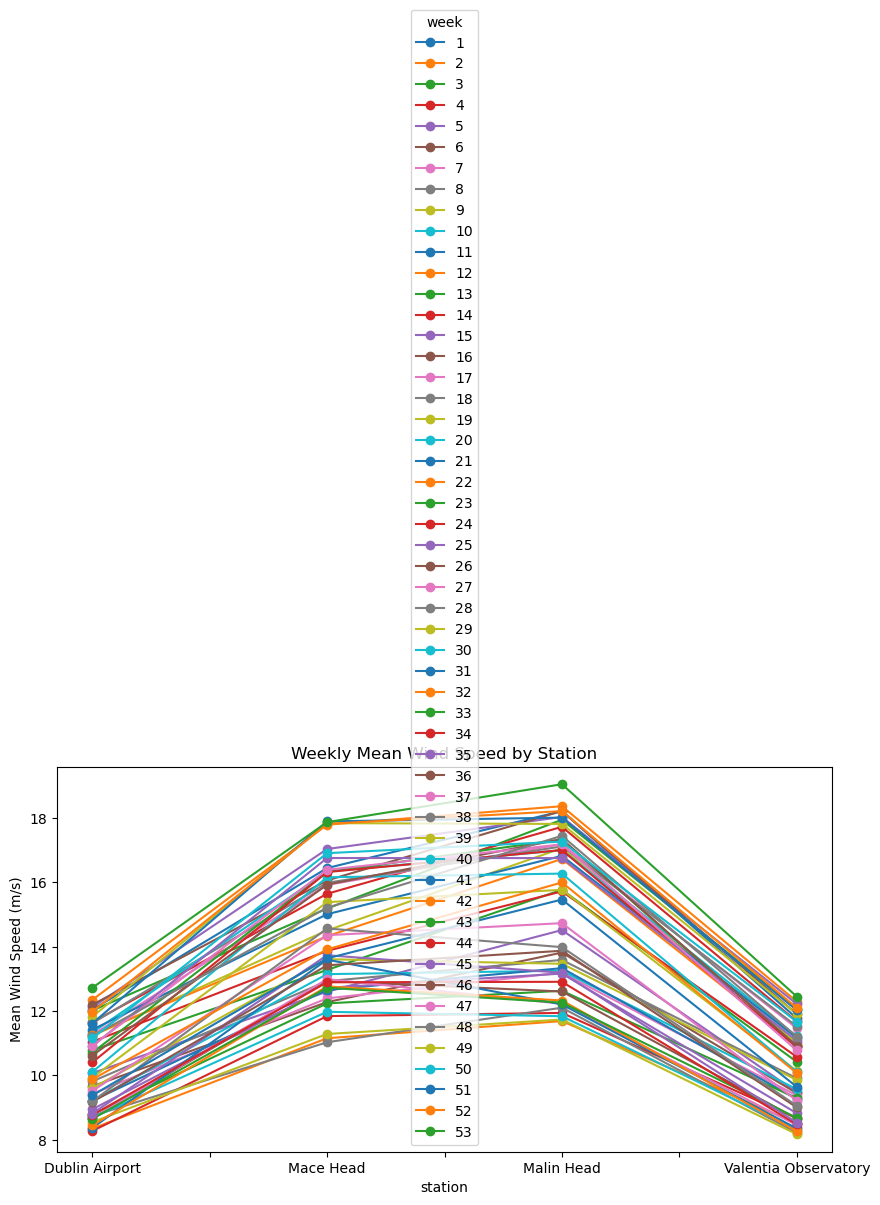

In [714]:
weekly_wind.plot(figsize=(10,5), marker='o')

plt.ylabel('Mean Wind Speed (m/s)')
plt.title('Weekly Mean Wind Speed by Station')
plt.show()

In [715]:
monthly_wind = combined_df.groupby(['station', 'month'])['wind_speed_ms'].mean().unstack()

print(monthly_wind)


month                       1         2         3         4         5   \
station                                                                  
Dublin Airport        6.182396  6.050885  5.743854  5.200355  4.770303   
Mace Head             8.421116  8.261706  7.501076  6.554380  6.655336   
Malin Head            9.274524  9.073304  8.558546  7.339695  6.772780   
Valentia Observatory  6.169120  6.033641  5.584701  5.024989  4.880541   

month                       6         7         8         9         10  \
station                                                                  
Dublin Airport        4.430629  4.454168  4.420050  4.841612  5.180692   
Mace Head             6.266863  6.183861  6.774713  7.311738  7.832702   
Malin Head            6.426589  6.212314  6.423341  7.452627  8.435806   
Valentia Observatory  4.532803  4.277689  4.346874  4.778593  5.292629   

month                       11        12  
station                                   
Dublin Airport        5.

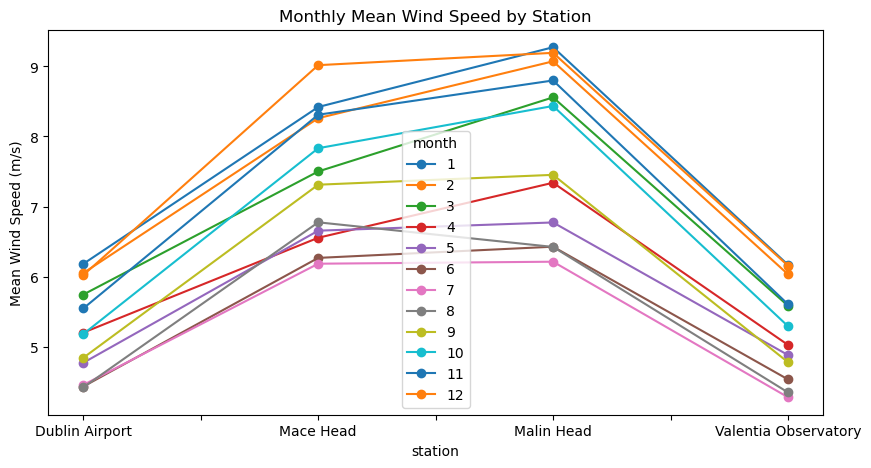

In [716]:
monthly_wind.plot(figsize=(10,5), marker='o')
plt.ylabel('Mean Wind Speed (m/s)')
plt.title('Monthly Mean Wind Speed by Station')
plt.show()  

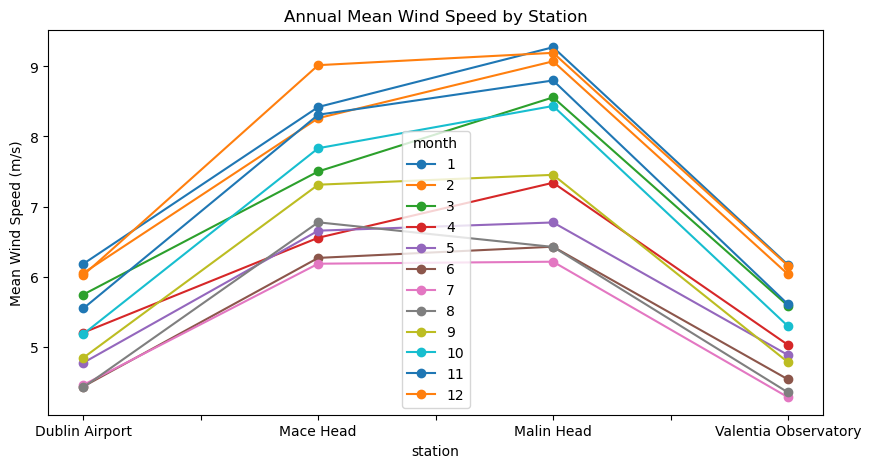

In [717]:
yearly_wind = combined_df.groupby(['station', 'year'])['wind_speed_ms'].mean().unstack()

monthly_wind.plot(figsize=(10,5), marker='o')
plt.ylabel('Mean Wind Speed (m/s)')
plt.title('Annual Mean Wind Speed by Station')
plt.show()


Text(0.5, 1.0, 'Monthly Mean Wind Speed by Station')

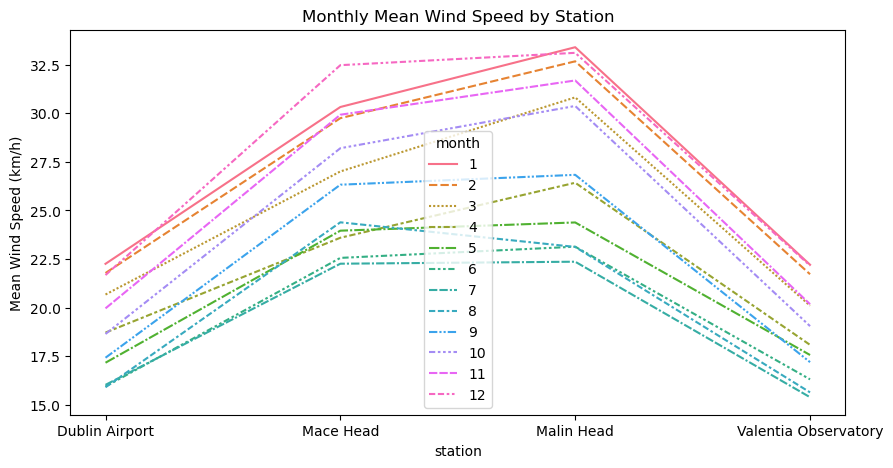

In [718]:
# Convert m/s to km/h
monthly_wind_kmh = monthly_wind * 3.6

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=monthly_wind_kmh, ax=ax)  
plt.ylabel('Mean Wind Speed (km/h)')
plt.title('Monthly Mean Wind Speed by Station')

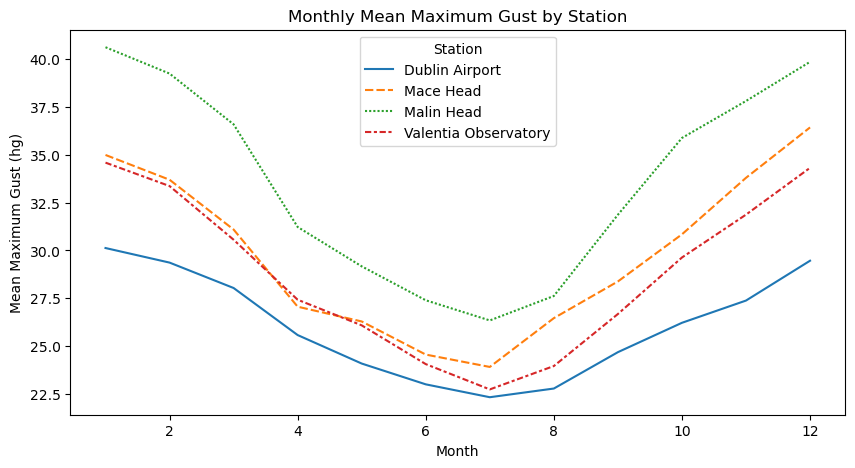

In [719]:


# Plot monthly hg by station
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=monthly_hg.T, ax=ax)  # Transpose to have months on x-axis
plt.ylabel('Mean Maximum Gust (hg)')
plt.xlabel('Month')
plt.title('Monthly Mean Maximum Gust by Station') 
plt.legend(title='Station')
plt.show()

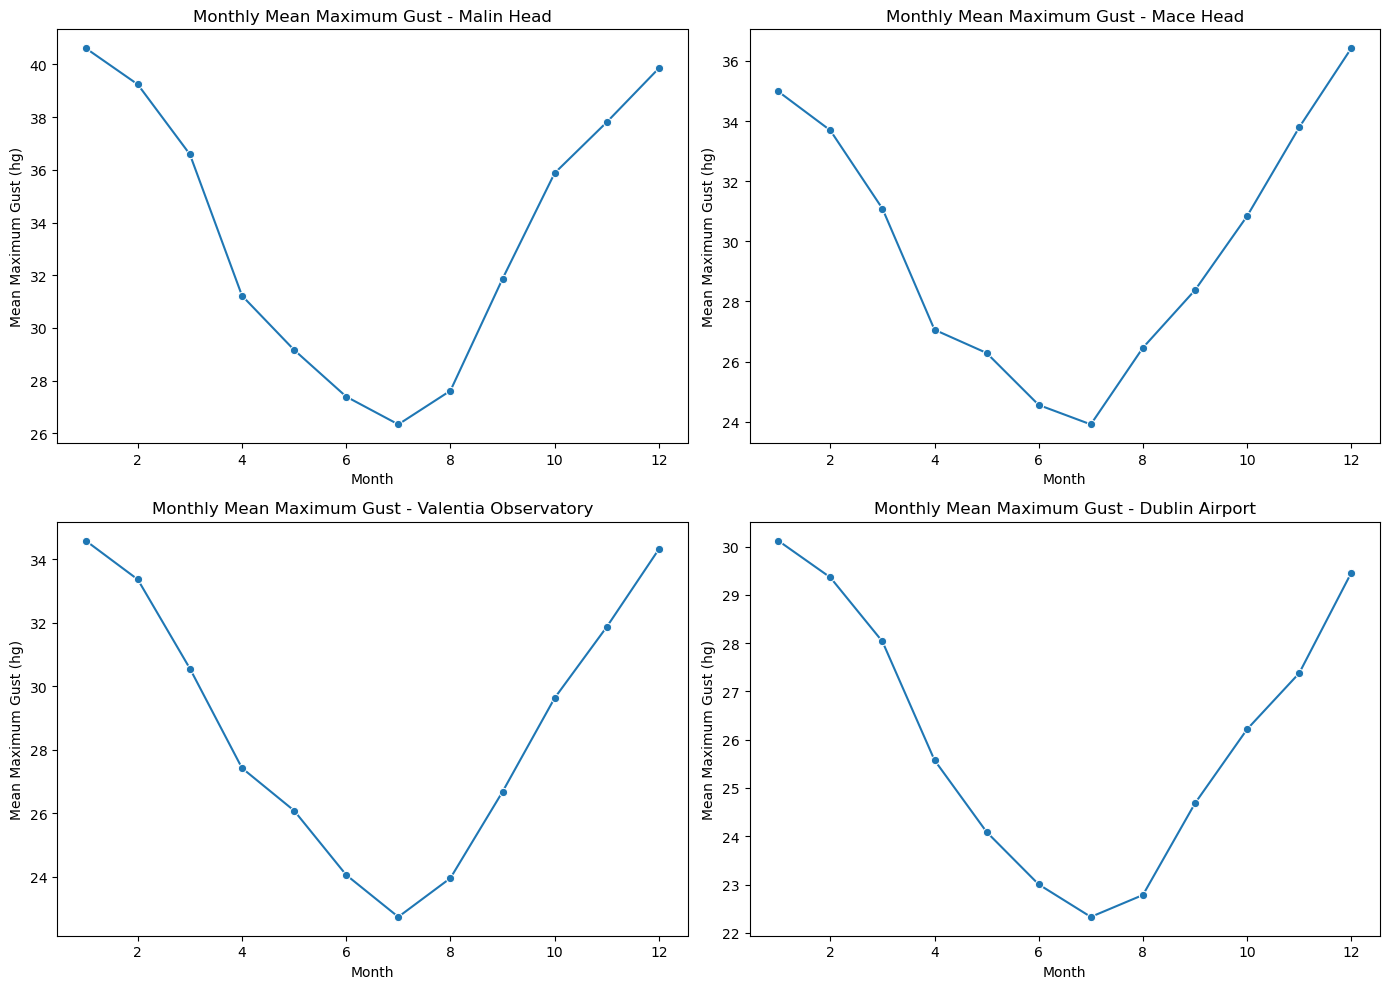

In [720]:
# Create subplots for all stations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, station in enumerate(stations.keys()):
    sns.lineplot(data=monthly_hg.loc[station], ax=axes[i], marker='o')
    axes[i].set_title(f'Monthly Mean Maximum Gust - {station}')
    axes[i].set_ylabel('Mean Maximum Gust (hg)')
    axes[i].set_xlabel('Month')
plt.tight_layout()
plt.show()

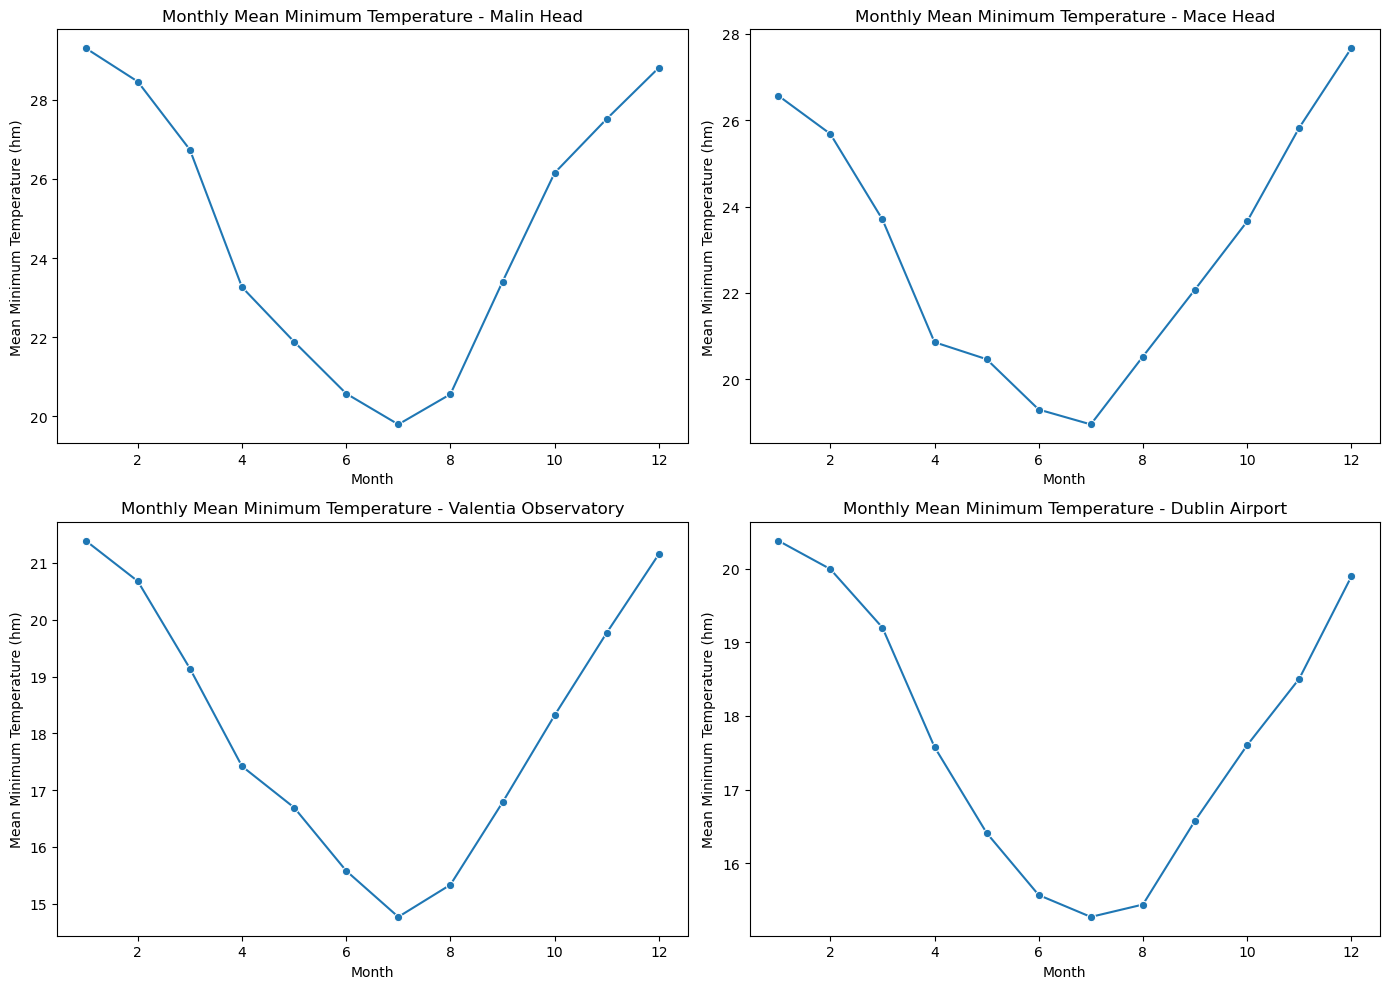

In [721]:
# Create subplots for all stations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, station in enumerate(stations.keys()):
    sns.lineplot(data=monthly_hm.loc[station], ax=axes[i], marker='o')
    axes[i].set_title(f'Monthly Mean Minimum Temperature - {station}')
    axes[i].set_ylabel('Mean Minimum Temperature (hm)')
    axes[i].set_xlabel('Month')
plt.tight_layout()
plt.show()

In [722]:
# Define the compass directions
compass_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
# Positions for these labels in degrees
compass_ticks = np.arange(0, 361, 45)

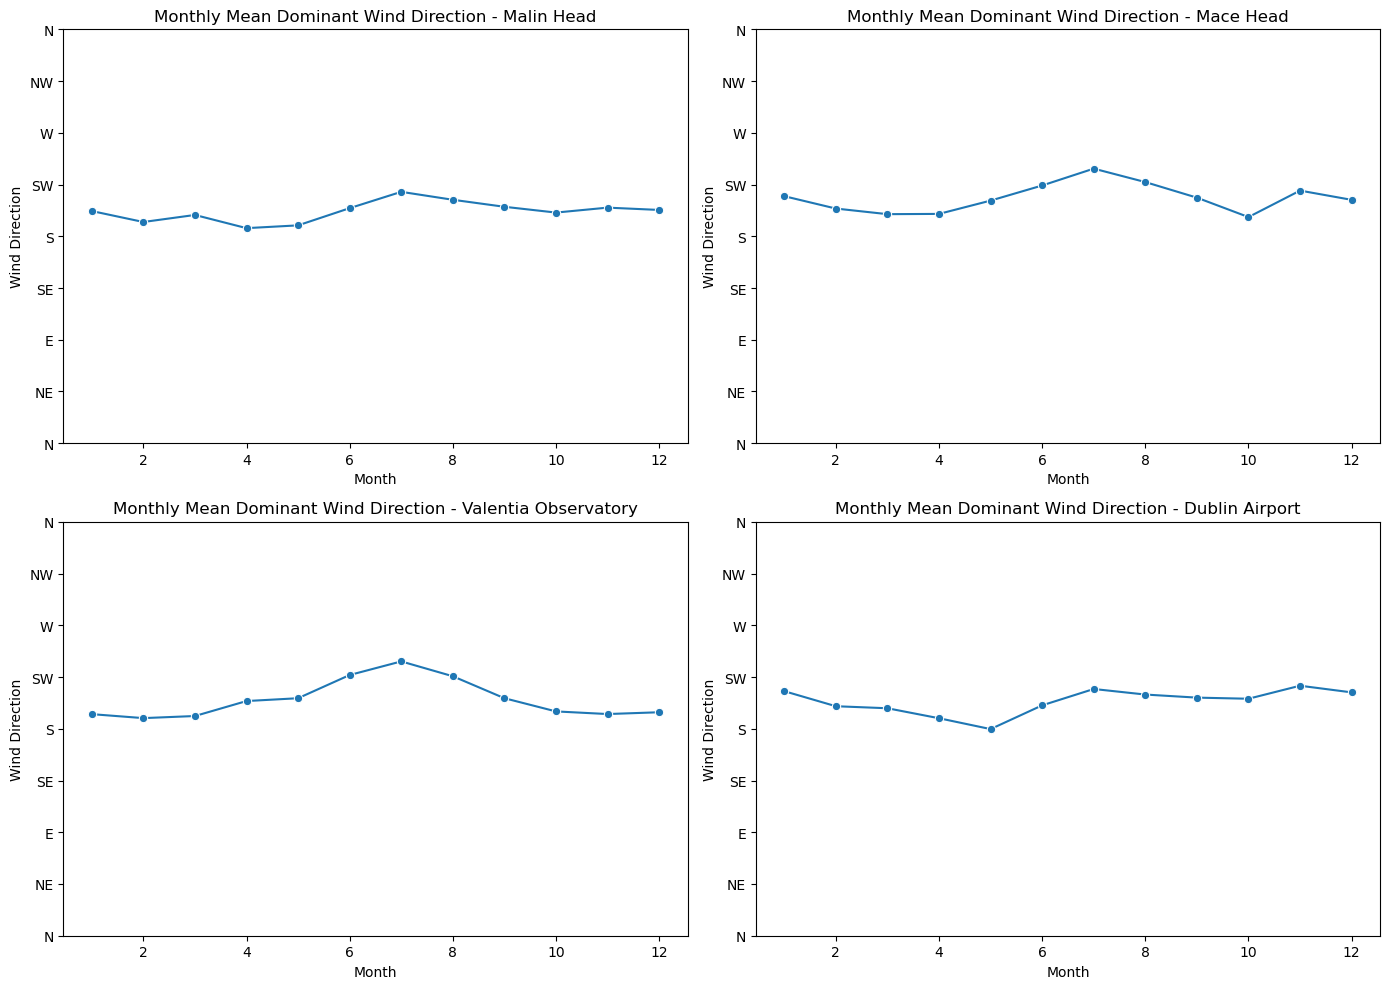

In [723]:
# Create subplots for all stations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, station in enumerate(stations.keys()):
    sns.lineplot(data=monthly_ddhm.loc[station], ax=axes[i], marker='o')
    
    axes[i].set_title(f'Monthly Mean Dominant Wind Direction - {station}')
    axes[i].set_ylabel('Wind Direction')
    axes[i].set_xlabel('Month')
    
    # Replace y-axis ticks with compass directions
    axes[i].set_yticks(compass_ticks)
    axes[i].set_yticklabels(compass_labels)
plt.tight_layout()
plt.show()